# Data Conversion to Epochs for MNE processing 

In [1]:
# Import needed packages 

import mne
import numpy as np
import matplotlib
import pathlib
import matplotlib.pyplot as plt
import scipy.signal as signal
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
import mne_bids
from mne_bids import BIDSPath, read_raw_bids
import mne_bids.stats 
import shutil
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy.linalg import svd
from mne.preprocessing import find_bad_channels_maxwell
from copy import deepcopy
import seaborn as sns
import pandas as pd
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog)
import scipy
from scipy.io import loadmat
from mne.externals.pymatreader import read_mat

In [2]:
# Load Raw Data

raw = read_mat('/Users/anastasiakuzmich/Downloads/Marios_data/Data.mat')
raw.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CarData', 'FaceData', 'CarData2', 'FaceData2', 'AllData', 'AllData2', 'stiml', 'stim'])

In [5]:
# Access file

data = raw['AllData2']
data.shape

(28620, 700)

In [6]:
# Reshape to tensor

data = data.reshape(477, 60, 700)

In [7]:
# Load channel locations

montage = mne.channels.make_standard_montage('biosemi64')

In [24]:
# Create info structure

ch_names = ['Fp1', 'Fp2', 'Fpz', 'AF3',  'AF4', 'AF7', 'AF8', 'F1', 'F3', 'F5', 'F7', 'Fz', 'F2', 'F4', 'F6', 'F8', 
            'FT7', 'FC5','FC3','FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'C1', 'C3', 'C5',  'Cz', 'C2', 'C4', 'C6', 
            'T8', 'TP7', 'TP8', 'T7','CP5', 'CP3', 'CP1',  'CP6', 'CP4', 'CP2', 'CPz', 'P1', 'P3', 'P5', 'P7', 'Pz', 
            'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']

ch_types = 'eeg'
sfreq = 1000  
montage = 'biosemi64'
tmin = -0.2

info = mne.create_info(ch_names, sfreq, ch_types)

In [10]:
# Access face vs car labels

task = raw['stim']
task.shape
print(task)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [26]:
# Access coherence labels

coherence = raw['stiml']
coherence.shape
print(coherence)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9

In [27]:
# Write events structure

a = [i for i in range(477)]
b = [700] * 477
c = coherence.tolist()

events = np.column_stack([a, b, c])

In [28]:
# Write events dictionary

event_id = {'face/1': 1, 
              'face/2': 2, 
              'face/3': 3,
              'face/4': 4, 
              'face/5': 5, 
              'face/6': 6,
              'car/1': 7, 
              'car/2': 8, 
              'car/3': 9,
              'car/4': 10, 
              'car/5': 11, 
              'car/6': 12}

In [29]:
# Create epochs structure

epochs = mne.EpochsArray(data, info, events, tmin, event_id)

print(epochs)

Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
<EpochsArray |  477 events (all good), -0.2 - 0.499 sec, baseline off, ~152.9 MB, data loaded,
 'car/1': 40
 'car/2': 40
 'car/3': 39
 'car/4': 39
 'car/5': 40
 'car/6': 40
 'face/1': 39
 'face/2': 40
 'face/3': 40
 'face/4': 40
 'face/5': 40
 'face/6': 40>


In [30]:
# Set channel locations

epochs.set_montage(montage)

Number of events,477
Events,car/1: 40car/2: 40car/3: 39car/4: 39car/5: 40car/6: 40face/1: 39face/2: 40face/3: 40face/4: 40face/5: 40face/6: 40
Time range,-0.200 – 0.499 sec
Baseline,off


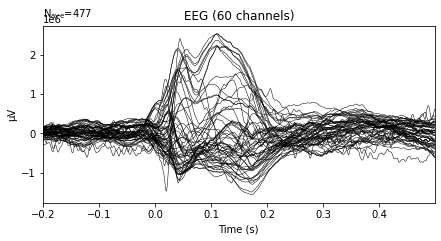

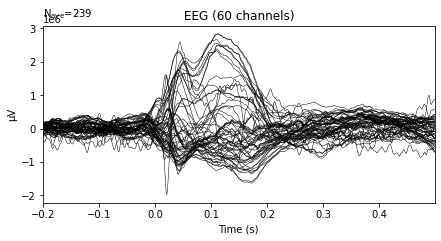

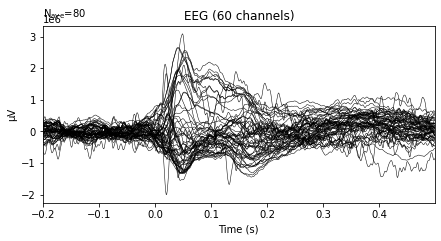

In [33]:
# Sanity check plots

_ = epochs.average().plot()
_ = epochs['face'].average().plot()
_ = epochs['6'].average().plot()

In [34]:
# Save epochs file

epochs.save('epochs-epo.fif', overwrite=True)